## Classify Reviews

In [23]:
######importing libraries for data manipulation#######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import math
from PIL import Image
import requests
from io import BytesIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import Perceptron
from spark_sklearn import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
import mord
from time import time
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st

In [54]:
###############Function definitions###########

#########Function definitions for separating related feature########
def change_vals_new_col(s,value,new_cols):
    
    if(value.get(s) != None):
        if((type(value[s]) == float) and np.isnan(value[s])):
            new_cols[s] = np.nan
        else:
            new_cols.get(s).append(value[s])
    else:
        new_cols.get(s).append(np.nan)
    

def generate_new_cols(related):
    
    new_cols = {'also_bought':[], 'also_viewed':[],'bought_together':[],'buy_after_viewing':[]}
    
    for key,value in related.items():
        if((type(value) == float) and np.isnan(value)):
            
            new_cols['also_bought'].append(np.nan)
            new_cols['also_viewed'].append(np.nan)
            new_cols['bought_together'].append(np.nan)
            new_cols['buy_after_viewing'].append(np.nan)
        else:
            change_vals_new_col('also_bought',value,new_cols)
            change_vals_new_col('also_viewed',value,new_cols)
            change_vals_new_col('bought_together',value,new_cols)
            change_vals_new_col('buy_after_viewing',value,new_cols)
            
        
    return new_cols
#####Function definitions for separating related feature ends####

def plot_related_prods(related,which,final_metadata):
    
    if(related == None):
        print('People who'+str(related)+'this product did not buy any other product:')
        return
    else:
        #print(np.array(related) in final_metadata.index)
        tot = 0
        for idx in related:
            if(idx in final_metadata.index):
                tot += 1
        print(tot)
        tot = round(tot/2)
        print('final',tot)
        f, axes = plt.subplots(tot,tot,figsize=(4,4),dpi=300)
        f.suptitle('People also '+str(which))
        for i in range(0,tot):
            for j in range(0,tot):
                curr_asin = related[i+j]
                if((curr_asin in final_metadata.index) == True):
                    curr_url = final_metadata.loc[curr_asin]['imUrl']
                    curr_title = final_metadata.loc[curr_asin]['title']
                    curr_title = curr_title[0:30]
                    response = requests.get(curr_url)
                    img = Image.open(BytesIO(response.content))
                    axes[i,j].imshow(img)
                    axes[i,j].get_xaxis().set_ticks([])
                    axes[i,j].get_yaxis().set_ticks([])
                    plt.axis('off')
                    axes[i,j].set_title(curr_title,size=3)
        plt.show()            

def Show_related_products(meta_data_row,final_metadata):
    
    #print(meta_data_row)
    curr_url = meta_data_row['imUrl']
    #curr_prod_id = meta_data_row['asin']
    title = meta_data_row['title']
    
    print('The current product is:',title)
    response = requests.get(curr_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.show()
    
    ####People who bought this product also bought####
    also_bought = meta_data_row['also_bought']
    if((type(also_bought) == float) and np.isnan(also_bought)):
        also_bought = None
    else:
        if(len(also_bought) > 9):
            also_bought = also_bought[0:9]
    plot_related_prods(also_bought,'bought',final_metadata)
    
    ####People who bought this product also viewed####
    also_viewed = meta_data_row['also_viewed']
    if((type(also_viewed) == float) and np.isnan(also_viewed)):
        also_viewed = None
    else:
        if(len(also_viewed) > 9):
            also_viewed = also_viewed[0:9]
    plot_related_prods(also_viewed,'viewed',final_metadata)


def bootStrap(learner,data,Y,size):
    
    train_acc = []
    test_acc = []
    train_f1 = []
    test_f1 = []
    data_merged = pd.concat([data,Y],axis=1)
    for i in range(0,size):
        #print(i)
        data_sampled = data_merged.sample(5000)
        
        X = data_sampled.iloc[:,0:(data_sampled.shape[1]-1)]
        Y = data_sampled.iloc[:,(data_sampled.shape[1]-1):data_sampled.shape[1]]
        
        #print(X.shape)
        #print(Y.shape)
        
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
        
        #print(X_train.shape)
        #print(y_train.shape)
        
        learner = learner.fit(X_train,y_train)
        
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        
        train_acc.append(accuracy_score(y_train,predictions_train))
        test_acc.append(accuracy_score(y_test,predictions_test))
        train_f1.append(f1_score(y_train,predictions_train))
        test_f1.append(f1_score(y_test,predictions_test))
        
    
    return train_acc,test_acc,train_f1,test_f1

def Hypothesis_test(sampling_dist,s1):
    
    train_acc_samp = sampling_dist[0] 
    test_acc_samp = sampling_dist[1]
    train_f1_samp = sampling_dist[2]
    test_f1_samp = sampling_dist[3]

    train_acc_mean = np.mean(train_acc_samp)
    train_acc_std = np.std(train_acc_samp)
    train_acc_SE = train_acc_std/np.sqrt(100) 
    print('Train accuracy mean of ',s1,' is',train_acc_mean)
    print('Train accuracy standard deviation of ',s1,' is',train_acc_std)
    print('Train accuracy Standard error of ',s1,' is',train_acc_SE)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    test_acc_mean = np.mean(test_acc_samp)
    test_acc_std = np.std(test_acc_samp)
    test_acc_SE = test_acc_std/np.sqrt(100)
    print('Test accuracy mean of ',s1,' is: ',test_acc_mean)
    print('Test accuracy standard deviation of ',s1,' is',test_acc_std)
    print('Test accuracy Standard error of ',s1,' is',test_acc_SE)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    train_f1_mean = np.mean(train_f1_samp)
    train_f1_std = np.std(train_f1_samp)
    train_f1_SE = train_f1_std/np.sqrt(100)
    print('Train f1 mean of ',s1,' is',train_f1_mean)
    print('Train f1 standard deviation of ',s1,' is',train_f1_std)
    print('Train f1 Standard error of ',s1,' is',train_f1_SE)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    test_f1_mean = np.mean(test_f1_samp)
    test_f1_std = np.std(test_f1_samp)
    test_f1_SE = test_f1_std/np.sqrt(100)
    print('Test f1 mean of ',s1,' is',test_f1_mean)
    print('Test f1 standard deviation of ',s1,' is',test_f1_std)
    print('Test f1 Standard error of ',s1,' is',test_f1_SE)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    dist = np.random.normal(loc=test_acc_mean,scale=test_acc_SE,size = 10000)
    density_prop = {"color": "green"}
    hist_prop = {"alpha": 0.3, "color": "red"}
    s = '95 % confidence interval of test accuracy of '+s1
    plot_densityCurve(dist,density_prop,hist_prop,100,5000,test_acc_mean,test_acc_SE,accuracy_naive,s)
    
    dist = np.random.normal(loc=test_f1_mean,scale=test_f1_SE,size = 10000)
    density_prop = {"color": "green"}
    hist_prop = {"alpha": 0.3, "color": "red"}
    s = '95 % confidence interval of test f_beta(0.5) score '+s1
    plot_densityCurve(dist,density_prop,hist_prop,100,5000,test_f1_mean,test_f1_SE,fscore_naive,s1)
    
    
    
def f_beta(y_true,y_pred,beta):
    
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)

    # TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
    fscore = ((1+beta*beta)*(precision*recall))/((beta*beta*precision)+recall)
    
    return fscore
    

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    X_train = X_train.astype(int)
    y_train = y_train.astype(int)
    X_test = X_test.astype(int)
    y_test = y_test.astype(int)
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:sample_size],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()

    results['f_train'] = f_beta(y_train[0:sample_size],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = f_beta(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("Train accuracy is:", results['acc_train'])
    print("Test accuracy is:", results['acc_test'])
    print("Train F-beta(0.5) score is:", results['f_train'])
    print("Test F-beta(0.5) is:", results['f_test'])
    print('_________________________________________')
    print('_________________________________________')
        
    # Return the results
    return results

def Naive_Bayes(X,Y,which,avg='binary'):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    print('Train accuracy score of ',which,' NB is: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 ',which,' NB is: ',f1_score(y_train, pred_train,average=avg))
    pred_test = clf.predict(X_test)
    print('Test accuracy score of ',which,' NB is: ',accuracy_score(y_test, pred_test, normalize=True))
    print('Test F-1 ',which,' NB is: ',f1_score(y_test, pred_test,average=avg))
    
def SVM(X,Y,which,avg = 'binary'):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    clf = SVC(kernel='rbf',C=2,gamma=20)
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    print('Train accuracy score of ',which,' SVM is: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 ',which,' SVM is: ',f1_score(y_train, pred_train,average=avg))
    pred_test = clf.predict(X_test)
    print('Test accuracy score of ',which,' SVM is: ',accuracy_score(y_test, pred_test, normalize=True))
    print('Test F-1 ',which,' SVM is: ',f1_score(y_test, pred_test,average=avg))
    
    
def Perceptron_classifier(X,Y,which,weights=None,avg='binary'):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    
    clf = Perceptron(max_iter=200,class_weight=weights)
    clf.fit(X_train,y_train)
    pred_train = clf.predict(X_train)
    
    print('Train accuracy score of ',which,' Perceptron: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 ',which,' Perceptron is: ',f1_score(y_train, pred_train,average=avg))
    pred_test = clf.predict(X_test)
    print('Test accuracy score of ',which,' Perceptron is: ',accuracy_score(y_test, pred_test, normalize=True))
    print('Test F-1 ',which,' Perceptron is: ',f1_score(y_test, pred_test,average=avg))
    
def Random_Forest(X,Y,which,avg='binary'):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
    clf.fit(X_train,y_train)
    pred_train = clf.predict(X_train)
    
    print('Train accuracy score of ',which,' RandomForest: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 ',which,' RandomForest is: ',f1_score(y_train, pred_train,average=avg))
    pred_test = clf.predict(X_test)
    print('Test accuracy score of ',which,' RandomForest is: ',accuracy_score(y_test, pred_test, normalize=True))
    print('Test F-1 ',which,' RandomForest is: ',f1_score(y_test, pred_test,average=avg))
    
def Ada_Boost(X,Y,which,avg='binary'):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    
    clf = AdaBoostClassifier(n_estimators=200)
    clf.fit(X_train,y_train)
    pred_train = clf.predict(X_train)
    
    print('Train accuracy score of ',which,' RandomForest: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 ',which,' RandomForest is: ',f1_score(y_train, pred_train,average=avg))
    pred_test = clf.predict(X_test)
    print('Test accuracy score of ',which,' RandomForest is: ',accuracy_score(y_test, pred_test, normalize=True))
    print('Test F-1 ',which,' RandomForest is: ',f1_score(y_test, pred_test,average=avg))
    
def Ordinal_Logistic_regression(X,Y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    
    X_train = X_train.astype(int)
    y_train = y_train.astype(int)
    X_test = X_test.astype(int)
    y_test = y_test.astype(int)
    
    clf = mord.LogisticIT()
    clf.fit(X_train,y_train)
    
    pred_train = clf.predict(X_train)
    #pred_train = np.round(pred_train,decimals=0)
    #pred_train.astype(int)
    print(pred_train[0:20])
    print(Y[0:20])
    print('Train accuracy score of multiclass ordinl Ridge regression is: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Train F-1 of multiclass ordinl Ridge regression is: ',f1_score(y_train, pred_train,average='weighted'))
    
    pred_test = clf.predict(X_test)
    #pred_test = np.round(pred_test,decimals=0)
    #pred_test.astype(int)
    print('Test accuracy score of multiclass ordinl Ridge regression is: ',accuracy_score(y_train, pred_train, normalize=True))
    print('Test F-1 of multiclass ordinl Ridge regression is: ',f1_score(y_train, pred_train,average='weighted'))

#######Reciever Operating Characteristics definitions###########

    
def ROC_AUC(classifier,X,y,which=None,c=None):
  
    X = np.array(X)
    y = np.array(y)
    y = np.reshape(y,(y.shape[0],1))
    title = 'ROC for Binary labels'
    
    if(which == 'multi'):
        y = label_binarize(y, classes=[1,2,3,4,5])
        title = 'ROC for multi-class labels'
        #f, axes = plt.subplots(3,2,figsize=(8,8),dpi=300)
        #f.suptitle('Distribution of drawing cards simulations')
        #m = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
    else:
        title = 'ROC for Binary labels'
        #f, axes = plt.subplots(1,2,figsize=(8,8),dpi=300)
        #f.suptitle('Distribution of drawing cards simulations')
        #m = [(0,0),(0,1)]
        
        
    print(y.shape)
    random_state = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=6)
    
    mean_fpr = np.linspace(0, 1, 100)
    
    for t in range(0,y.shape[1]):
        i = 0
        tprs = []
        aucs = []
        #a = m[t][0]
        #b = m[t][1]
        #print(a)
        #print(b)
        for train, test in cv.split(X, y[:,t]):
            #print(y[train].shape)
            
            if(c == 'p'):
                probas_ = classifier.fit(X[train], y[train,t]).score(X[test],y[test,t])
            else:
                probas_ = classifier.fit(X[train], y[train,t]).predict_proba(X[test])
            # Compute ROC curve and area the curve
            
            fpr, tpr, thresholds = roc_curve(y[test,t], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))        
            i = i + 1
   
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
               
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
               
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if(which == 'multi'):
            plt.title(title+' for rating = '+str(t+1))
        else:
            plt.title(title)
        
        plt.legend(loc="lower right")
        plt.show()

def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (30,20))

    # Constants
    bar_width = 0.15
    colors = ['#A00000','#00A0A0','#00A000','orange','purple']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size",fontsize = 26)
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)",fontsize = 26)
    ax[0, 1].set_ylabel("Accuracy Score",fontsize = 26)
    ax[0, 2].set_ylabel("F-beta(0.5)",fontsize = 26)
    ax[1, 0].set_ylabel("Time (in seconds)",fontsize = 26)
    ax[1, 1].set_ylabel("Accuracy Score",fontsize = 26)
    ax[1, 2].set_ylabel("F-beta(0.5)",fontsize = 26)
    
    # Add titles
    ax[0, 0].set_title("Model Training",fontsize = 26)
    ax[0, 1].set_title("Accuracy Score on Training Subset",fontsize = 26)
    ax[0, 2].set_title("F-beta(0.5) on Training Subset",fontsize = 26)
    ax[1, 0].set_title("Model Predicting",fontsize = 26)
    ax[1, 1].set_title("Accuracy Score on Testing Set",fontsize = 26)
    ax[1, 2].set_title("F-beta(0.5) on Testing Set",fontsize = 26)
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches,bbox_to_anchor=(0.5, 1,0.5,0.5), loc='upper center',ncol = 3, fontsize = 26)
    
    # Aesthetics
    #plt.figlegend( 'Ruchin', 'Patel', loc = 'lower center', ncol=5, labelspacing=0. )
    plt.suptitle("Performance Metrics for 5 Supervised Learning Models", fontsize = 26, y = 1.10)
    plt.tight_layout()
    plt.show()
        
def plot_densityCurve(*args):
    plt.figure(figsize=(9,4), dpi=300)
    sns.distplot(args[0],kde_kws=args[1])
    plt.axvline(args[5], color='yellow', linestyle='-.', linewidth=1,label='sample mean')
    plt.axvline(args[5]-args[6], color='black', linestyle=':', linewidth=1,label='1 standard dev')
    plt.axvline(args[5]+args[6], color='black', linestyle=':', linewidth=1)
    plt.axvline(args[7], color='purple', linestyle='-.', linewidth=2,label='True mean')
    plt.axvline(args[5]-(1.96*args[6]),color='black',linewidth=2,label='95% confidence line')
    plt.axvline(args[5]+(1.96*args[6]),color='black',linewidth=2)
    #plt.xlim(0.72,0.85)
    plt.legend()
    #plt.title("The sampling distribution with "+str(args[3])+" samples of size n="+str(args[4]))
    plt.title(args[8])
    plt.show()  
    
def plot_norm(sample_mean,SE,*args):
    plt.figure(figsize=(9,4), dpi=300)
    x_values = np.random.normal(loc = sample_mean,scale=SE,size=args[0])
    x_values = np.sort(x_values)
    y_values = st.norm.pdf(x_values,loc = sample_mean,scale=SE)
    plt.plot(x_values,y_values,linewidth=2,color='green')
    plt.axvline(sample_mean, color='yellow', linestyle='-.', linewidth=2,label='sample mean')
    plt.axvline(sample_mean-SE, color='black', linestyle=':', linewidth=1,label='1 standard dev')
    plt.axvline(sample_mean+SE, color='black', linestyle=':', linewidth=1)
    plt.axvline(args[1], color='purple', linestyle='-', linewidth=1,label='95% confidence line')
    plt.axvline(args[2], color='purple', linestyle='-', linewidth=1)
    x_95 = x_values[np.logical_and(x_values>=args[1],x_values<=args[2])]
    y_95 = y_values[np.logical_and(x_values>=args[1],x_values<=args[2])]
    plt.fill_between(x_95,0,y_95,color='red',alpha=0.4)
    #plt.ylim(0,10)
    plt.legend()
    plt.show()  
        


### Read Data In

In [3]:
#####Reading Data#######
#####This is a smaller data for initial data exploration and model testing#####
######The data is about Heal and Personal care Products on Amazon##########

def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/Health_and_Personal_Care_5.json'
metadata_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/meta_Health_and_Personal_Care.json'

data = getDF(data_path)
metadata = getDF(metadata_path)

* As seen from the table above the field related has two sub values $\textbf{also_bought}$ and $\textbf{also_viewed}$ and as a result of this we need to make two new columns for it.

In [5]:
########## Generating seperate columns for related feature######
related = metadata['related'].to_dict()
newly_created_columns = pd.DataFrame(generate_new_cols(related))

In [6]:
#########Final Metadata dataframe###########
final_metadata = pd.concat([metadata,newly_created_columns],axis = 1)
final_metadata = final_metadata.drop('related',axis=1)
final_metadata = final_metadata.set_index('asin')

######converting the dates to date time format#####
data['unixReviewTime'] = pd.to_datetime(data['unixReviewTime'],unit='s')
data['reviewTime'] = pd.to_datetime(data['reviewTime'])

In [7]:
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,2011-01-05,2011-01-05
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,2012-02-18,2012-02-18
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,2010-06-08,2010-06-08
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,2008-02-08,2008-02-08
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,2011-08-16,2011-08-16


In [8]:
final_metadata.head(5)

,description,title,imUrl,salesRank,categories,price,brand,also_bought,also_viewed,bought_together,buy_after_viewing
asin,,,,,,,,,,,
0077614992,This is an example product description.,Principles of Mgmt + Oper-CSUF Custom C,http://ecx.images-amazon.com/images/I/51G%2BRq...,{'Health & Personal Care': 168429},[[Health & Personal Care]],NaN,NaN,"[0471730726, 0132834871, 0471391905, B00000JZK...","[0073525057, 1133227295, 0324628676, 0073523224]",NaN,NaN
0615208479,By now we all know the benefits of exercise fo...,Brain Fitness Exercises Software,http://ecx.images-amazon.com/images/I/41kbZB04...,{'Health & Personal Care': 1346973},"[[Health & Personal Care, Personal Care]]",NaN,NaN,NaN,NaN,NaN,NaN
0615269990,What's wrong with your patient?Do all the symp...,Occam's Razor,http://ecx.images-amazon.com/images/I/51fH-ABe...,{'Toys & Games': 110575},"[[Health & Personal Care, Personal Care, Shavi...",34.99,NaN,"[1935660152, 0071743979, 0071831428, 032308787...","[1594741476, B0069628EU, B009RTGX2Y, B000IQHSL...",NaN,NaN
0615315860,NaN,101 BlenderBottle Recipes Quick and Easy,http://ecx.images-amazon.com/images/I/21zOQu2Q...,{'Health & Personal Care': 254068},[[Health & Personal Care]],NaN,NaN,"[B006VT9RBM, B0010JLMO8, B001CXC69C, B0064QSHX...",[B0018G4ZEW],NaN,NaN
0615406394,This is an example product description.,"Aphrodite Reborn - Women's Stories of Hope, Co...",http://ecx.images-amazon.com/images/I/51rJLgsi...,{'Health & Personal Care': 377936},[[Health & Personal Care]],NaN,NaN,"[0966035232, 1421407205]",NaN,NaN,NaN


In [9]:
reviews_data = data[['reviewText','overall']]
reviews_data_binary = data[['reviewText','overall']]
replace = {1:0,2:0,3:0,4:1,5:1}
reviews_data['overall_binary'] = reviews_data[['overall']].replace(to_replace=replace,value=None)

#print(reviews_data.shape)
#print(reviews_data_binary.shape)
#print(np.unique(reviews_data_binary['overall']))
#reviews_data[['overall','overall_binary']].head(10)

In [10]:
print('Total ratings of all classes')
print()
print()
ratings_count = reviews_data.groupby(by='overall').count()
ratings_count['reviewTextPercent'] = ratings_count['reviewText']*100/np.sum(ratings_count['reviewText'])
ratings_count['classWeights'] = 20/ratings_count['reviewTextPercent']
print(ratings_count[['reviewText','reviewTextPercent','classWeights']])

Total ratings of all classes


         reviewText  reviewTextPercent  classWeights
overall                                             
1.0           16546           4.777179      4.186571
2.0           16754           4.837233      4.134595
3.0           33254           9.601132      2.083088
4.0           68168          19.681541      1.016181
5.0          211633          61.102915      0.327317


In [11]:
#####Tokenizing our text data####
count_vect = CountVectorizer(analyzer = 'word',stop_words = 'english',min_df=0.01,binary=False)
review_text_tokenized = count_vect.fit_transform(reviews_data['reviewText'])

In [12]:
print(review_text_tokenized.shape)
review_text_tokenized = pd.DataFrame(review_text_tokenized.toarray())
ratings_multi = reviews_data['overall']
ratings_binary = reviews_data['overall_binary']

(346355, 625)


In [13]:
X_red_tr, X_red_tt, y_red_tr, y_red_tt = train_test_split(review_text_tokenized,ratings_binary,train_size=0.02, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_red_tr,y_red_tr,test_size=0.2, random_state=42)
 

In [28]:
####### We will first construct a Naive predictor#####
##### Predicts everything as 5 stars as it is the maximum######
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(review_text_tokenized,ratings_binary,test_size=0.2, random_state=42)
naive_pred = np.ones(shape=y_test_n.shape)
accuracy_naive = accuracy_score(y_test_n,naive_pred)
precision_naive = precision_score(y_test_n,naive_pred)
recall_naive = recall_score(y_test_n,naive_pred)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.

fscore_naive = f_beta(y_test_n,naive_pred,0.5)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, Precesion: {:.4f}, Recall: {:.4f}, F-score: {:.4f}]".format(accuracy_naive,precision_naive,recall_naive,fscore_naive))

Naive Predictor: [Accuracy score: 0.8080, Precesion: 0.8080, Recall: 1.0000, F-score: 0.8403]


MultinomialNB trained on 55 samples.
Train accuracy is: 1.0
Test accuracy is: 0.7467532467532467
Train F-beta(0.5) score is: 1.0
Test F-beta(0.5) is: 0.8300830930981856
_________________________________________
_________________________________________
MultinomialNB trained on 554 samples.
Train accuracy is: 0.8916967509025271
Test accuracy is: 0.7734487734487735
Train F-beta(0.5) score is: 0.924149956408021
Test F-beta(0.5) is: 0.8429599866063956
_________________________________________
_________________________________________
MultinomialNB trained on 5541 samples.
Train accuracy is: 0.8413643746616134
Test accuracy is: 0.8354978354978355
Train F-beta(0.5) score is: 0.8895314227400287
Test F-beta(0.5) is: 0.879979828542612
_________________________________________
_________________________________________
RandomForestClassifier trained on 55 samples.
Train accuracy is: 0.8909090909090909
Test accuracy is: 0.8037518037518038
Train F-beta(0.5) score is: 0.9090909090909091
Test F-beta(

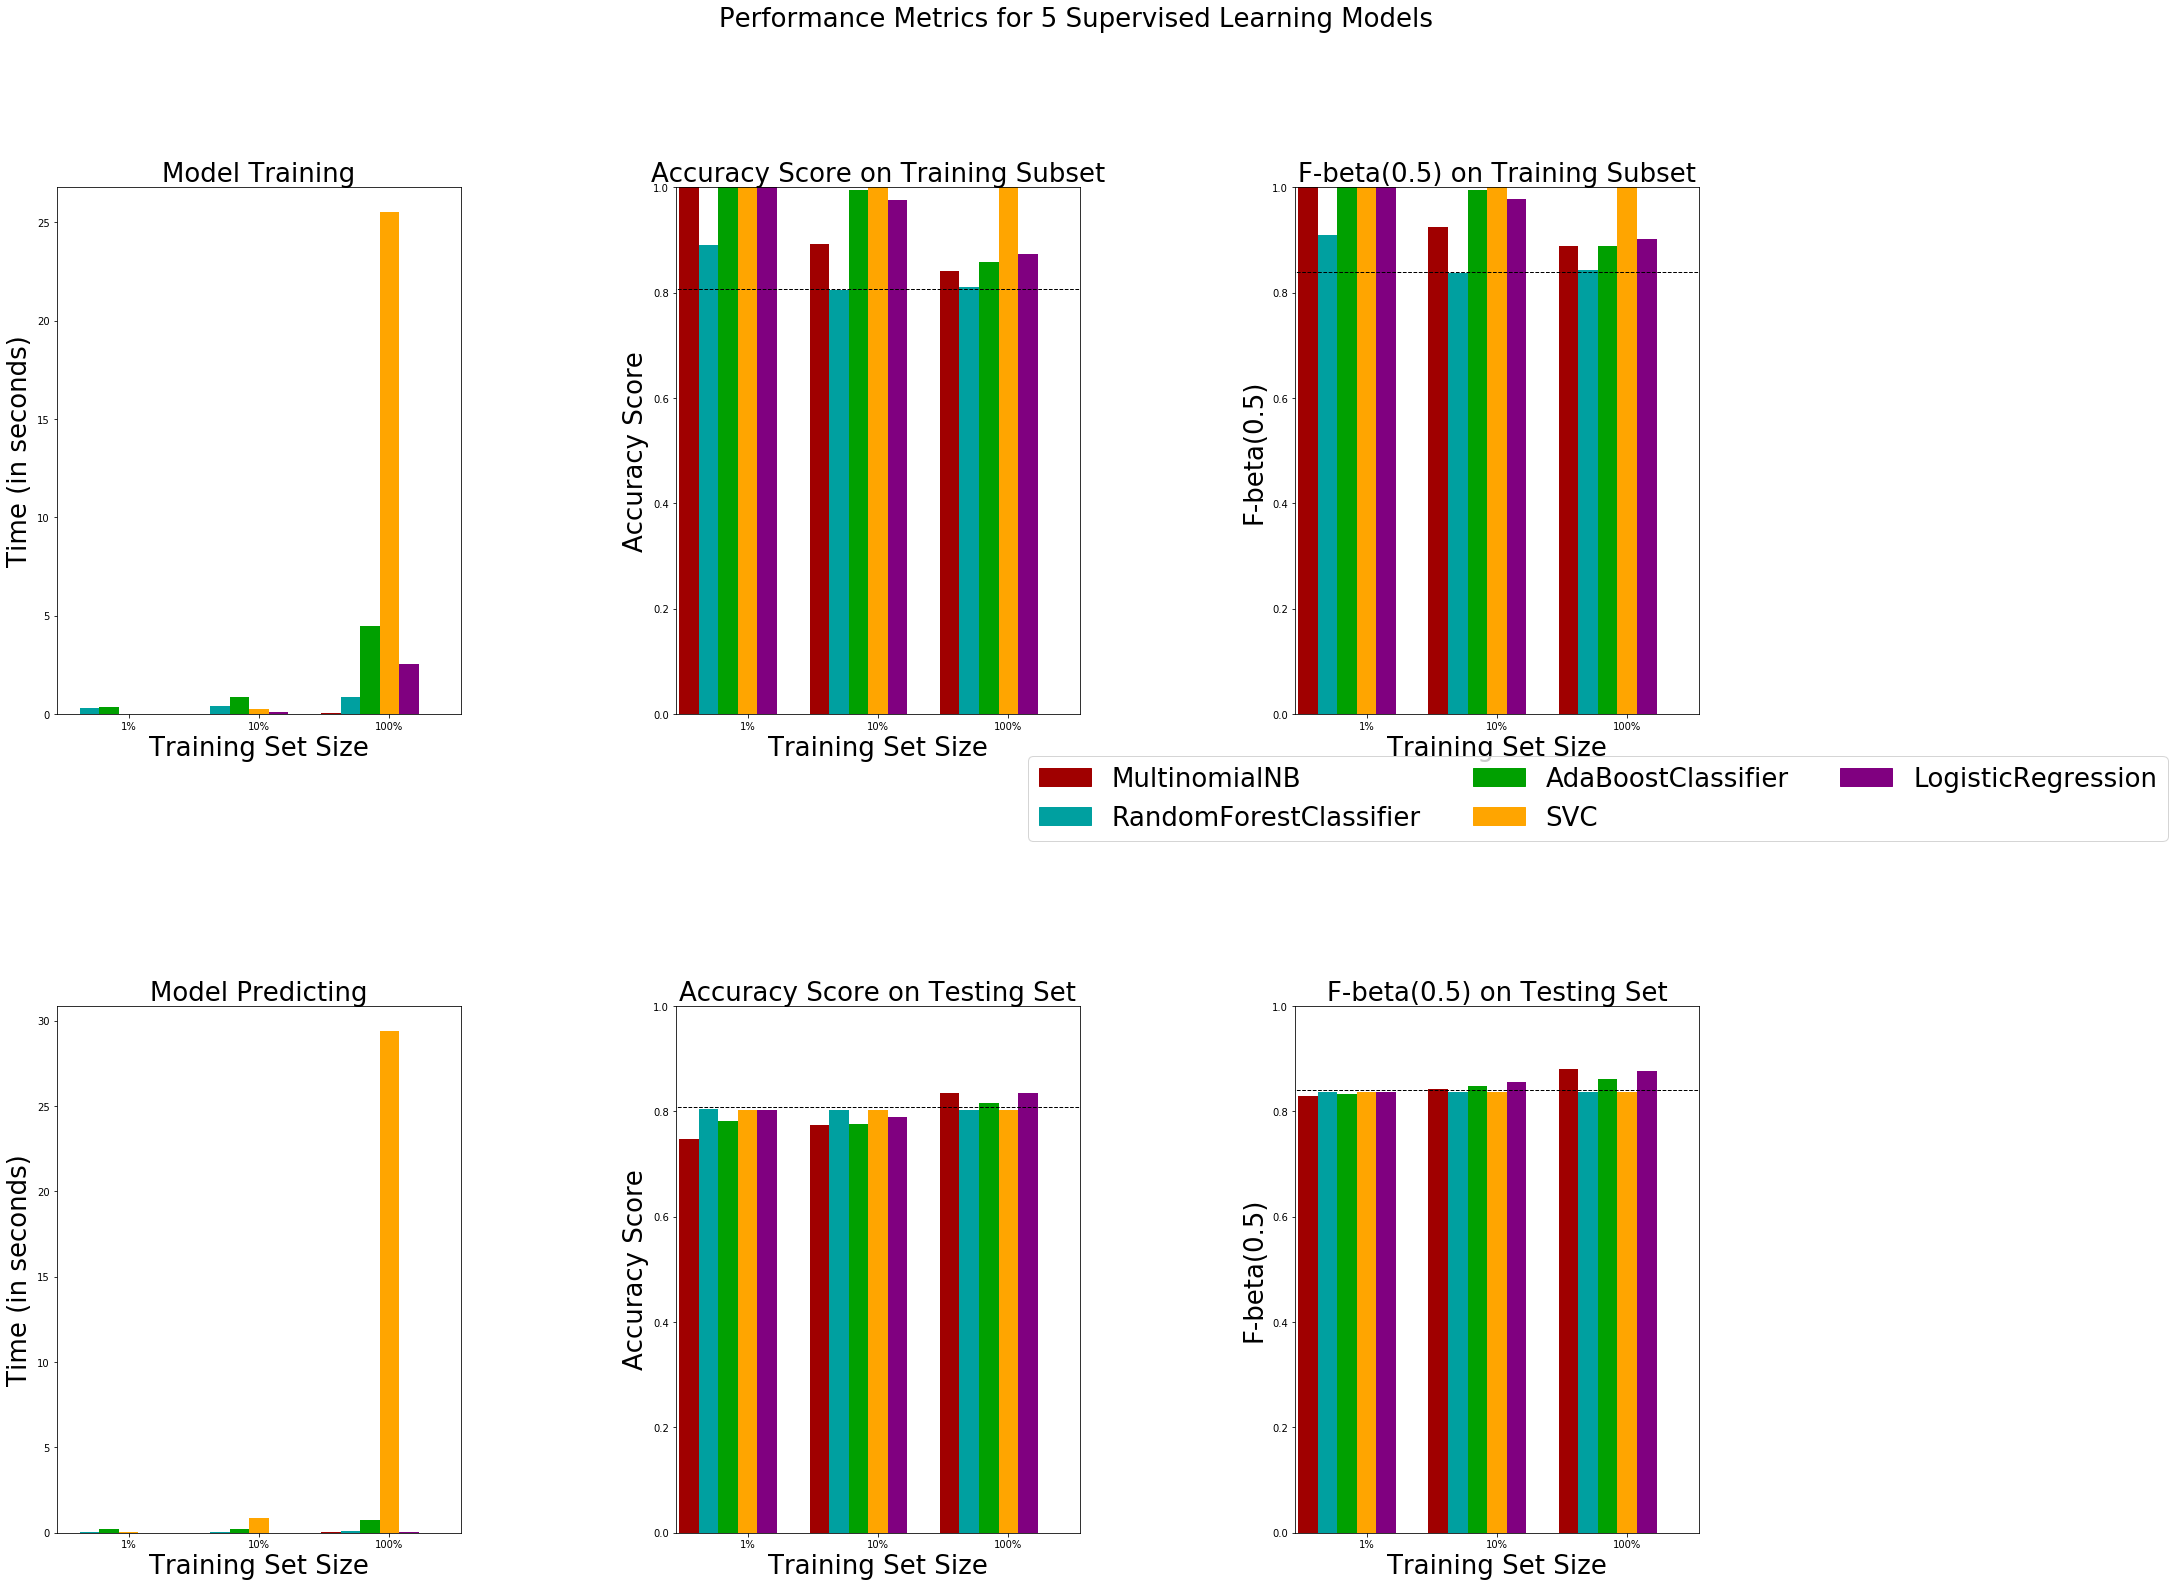

In [24]:
clf_A = MultinomialNB()
clf_B = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
clf_C = AdaBoostClassifier(n_estimators=200,random_state=0)
clf_D = SVC(kernel='rbf',C=2,gamma=20)
clf_E = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_ train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(y_train))
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D,clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

In [55]:
sampling_dist = bootStrap(LogisticRegression(),review_text_tokenized,ratings_binary,100)

Train accuracy mean of  Logistic Regression  is 0.8867725000000002
Train accuracy standard deviation of  Logistic Regression  is 0.005713590705502104
Train accuracy Standard error of  Logistic Regression  is 0.0005713590705502104
-----------------------------------------------------------
-----------------------------------------------------------
Test accuracy mean of  Logistic Regression  is:  0.8100299999999997
Test accuracy standard deviation of  Logistic Regression  is 0.012975711926518682
Test accuracy Standard error of  Logistic Regression  is 0.0012975711926518682
-----------------------------------------------------------
-----------------------------------------------------------
Train f1 mean of  Logistic Regression  is 0.9328029843184473
Train f1 standard deviation of  Logistic Regression  is 0.0035551656749264657
Train f1 Standard error of  Logistic Regression  is 0.0003555165674926466
-----------------------------------------------------------
----------------------------

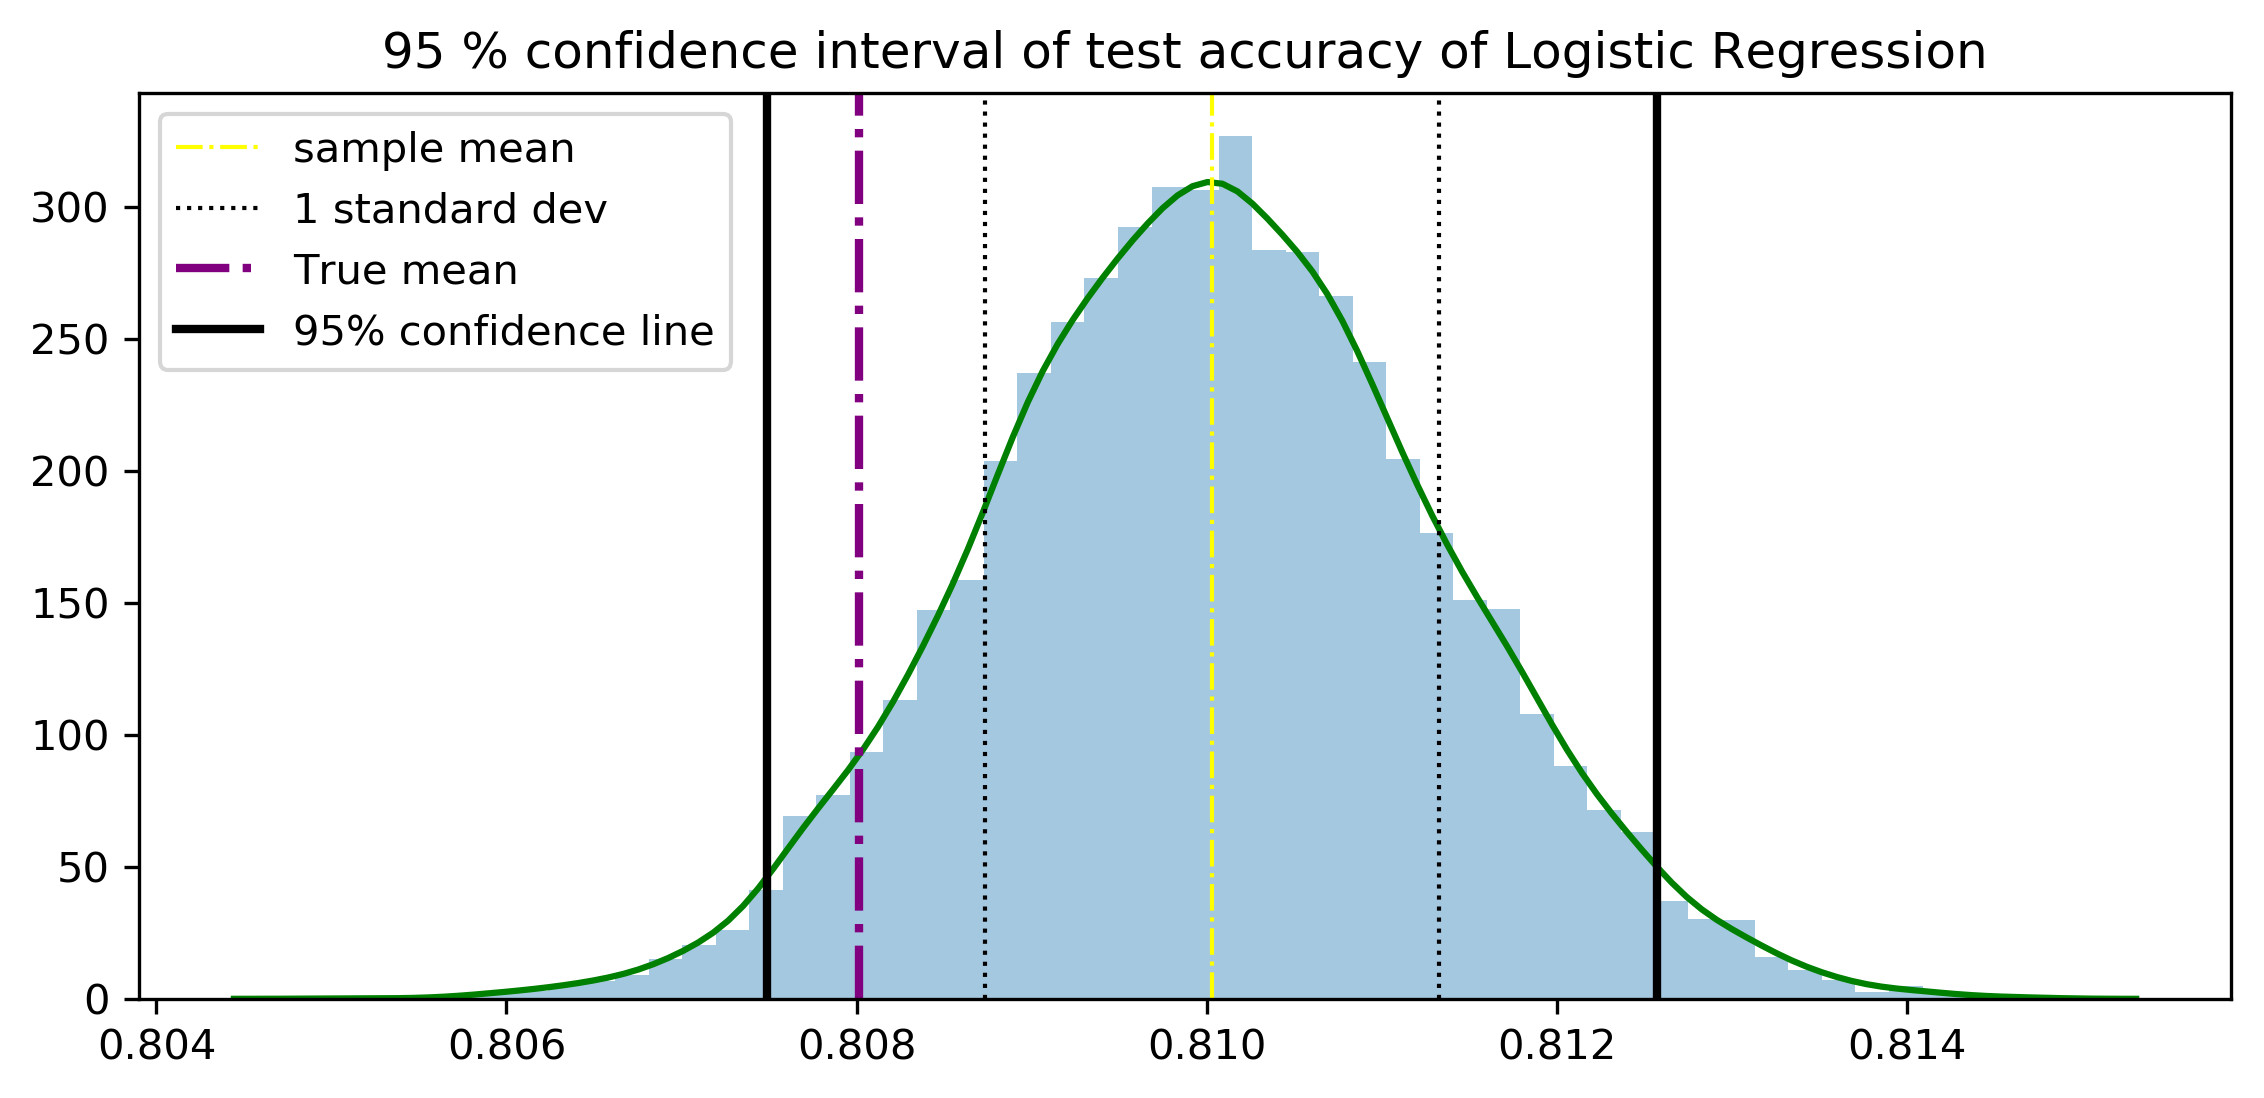

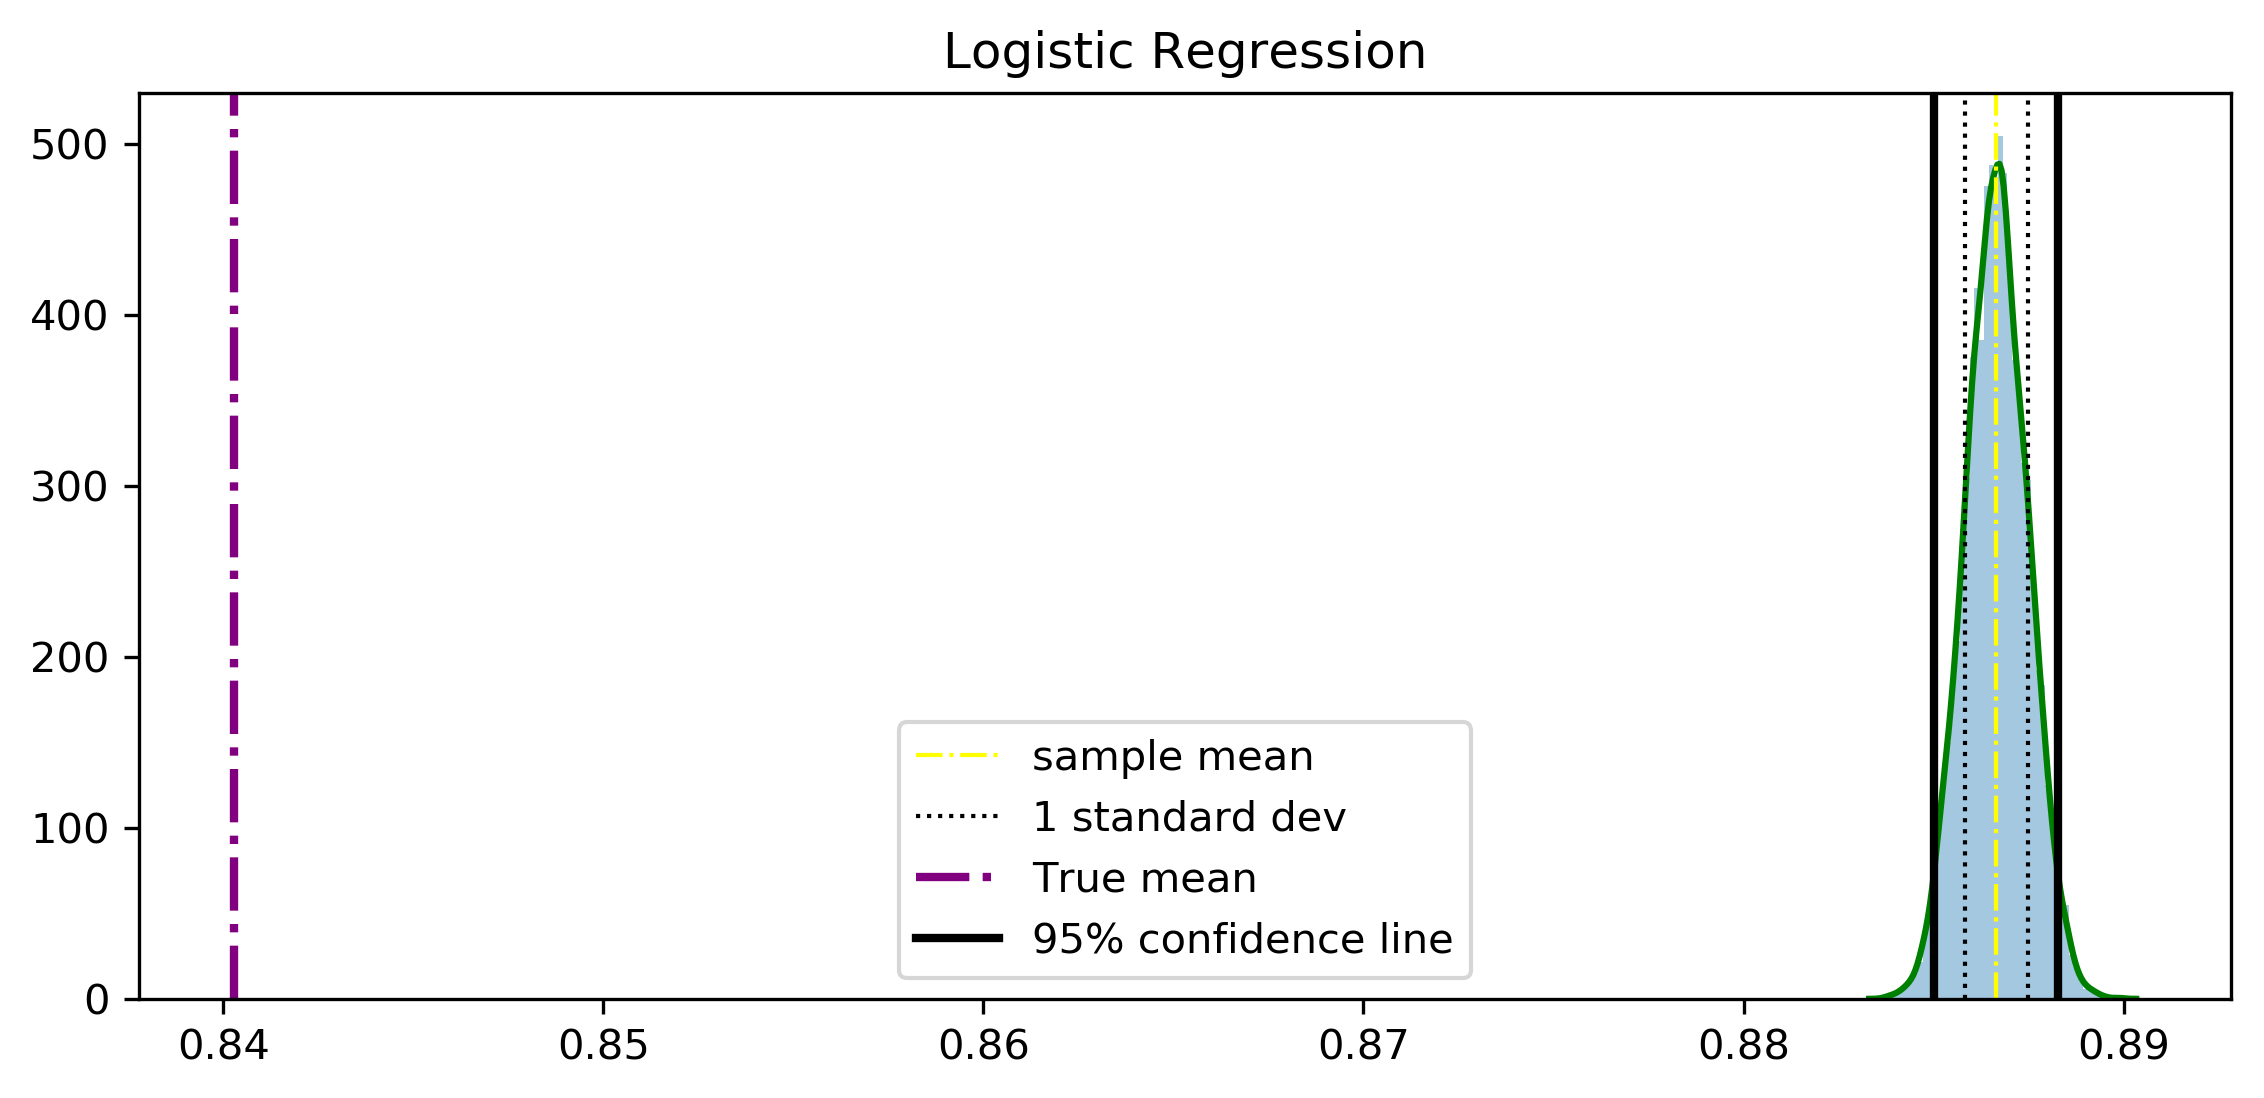

In [56]:
Hypothesis_test(sampling_dist,'Logistic Regression')

In [57]:
sampling_dist = bootStrap(AdaBoostClassifier(n_estimators=200,random_state=0),review_text_tokenized,ratings_binary,100)

Train accuracy mean of  AdaBoost  is 0.8656349999999999
Train accuracy standard deviation of  AdaBoost  is 0.005588092250491227
Train accuracy Standard error of  AdaBoost  is 0.0005588092250491227
-----------------------------------------------------------
-----------------------------------------------------------
Test accuracy mean of  AdaBoost  is:  0.8140599999999999
Test accuracy standard deviation of  AdaBoost  is 0.012219508991772097
Test accuracy Standard error of  AdaBoost  is 0.0012219508991772098
-----------------------------------------------------------
-----------------------------------------------------------
Train f1 mean of  AdaBoost  is 0.9209622644309363
Train f1 standard deviation of  AdaBoost  is 0.0035689581026453958
Train f1 Standard error of  AdaBoost  is 0.0003568958102645396
-----------------------------------------------------------
-----------------------------------------------------------
Test f1 mean of  AdaBoost  is 0.8906216928407236
Test f1 standard d

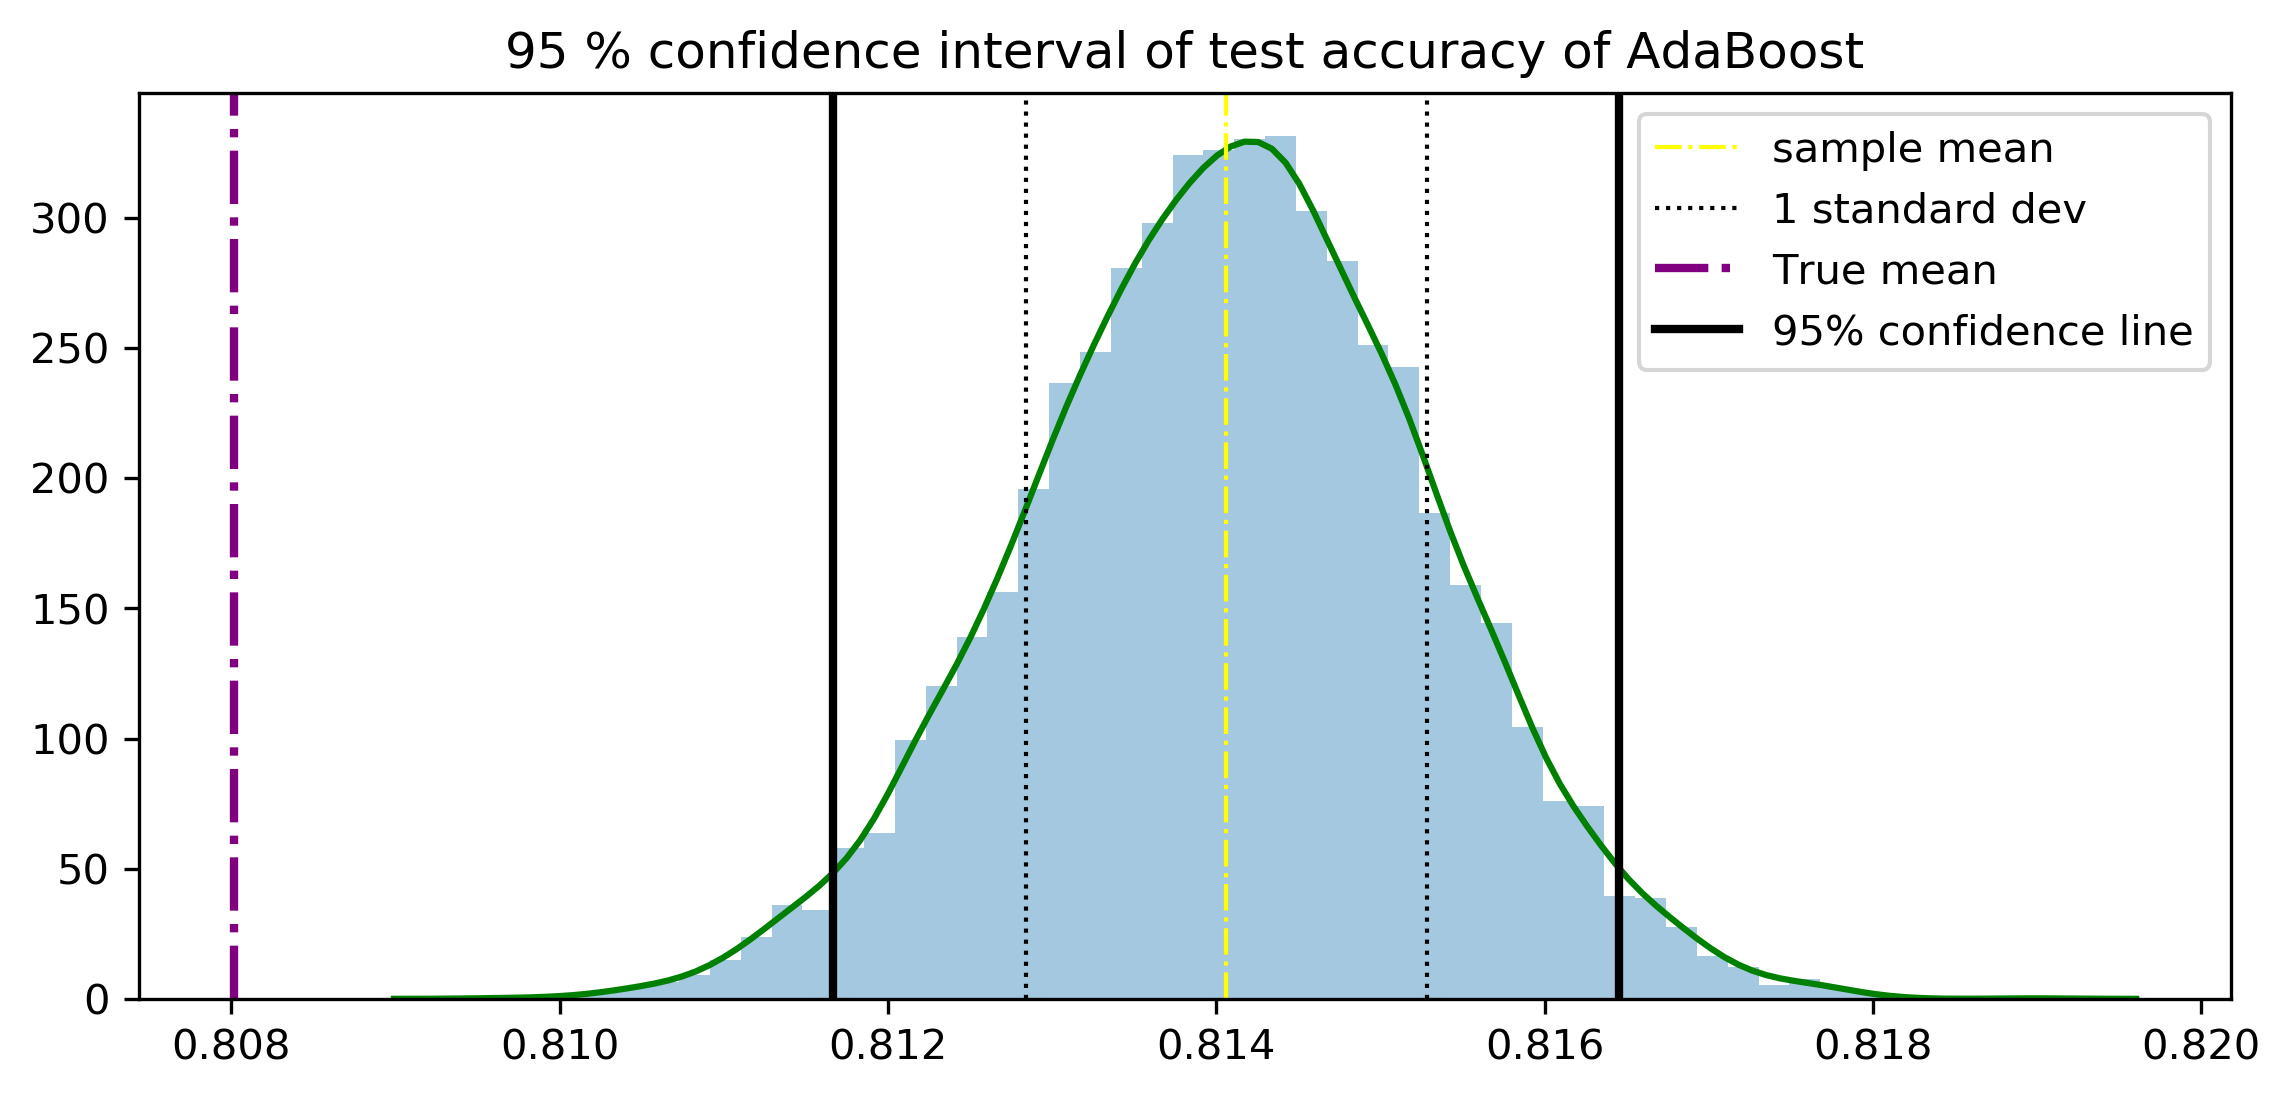

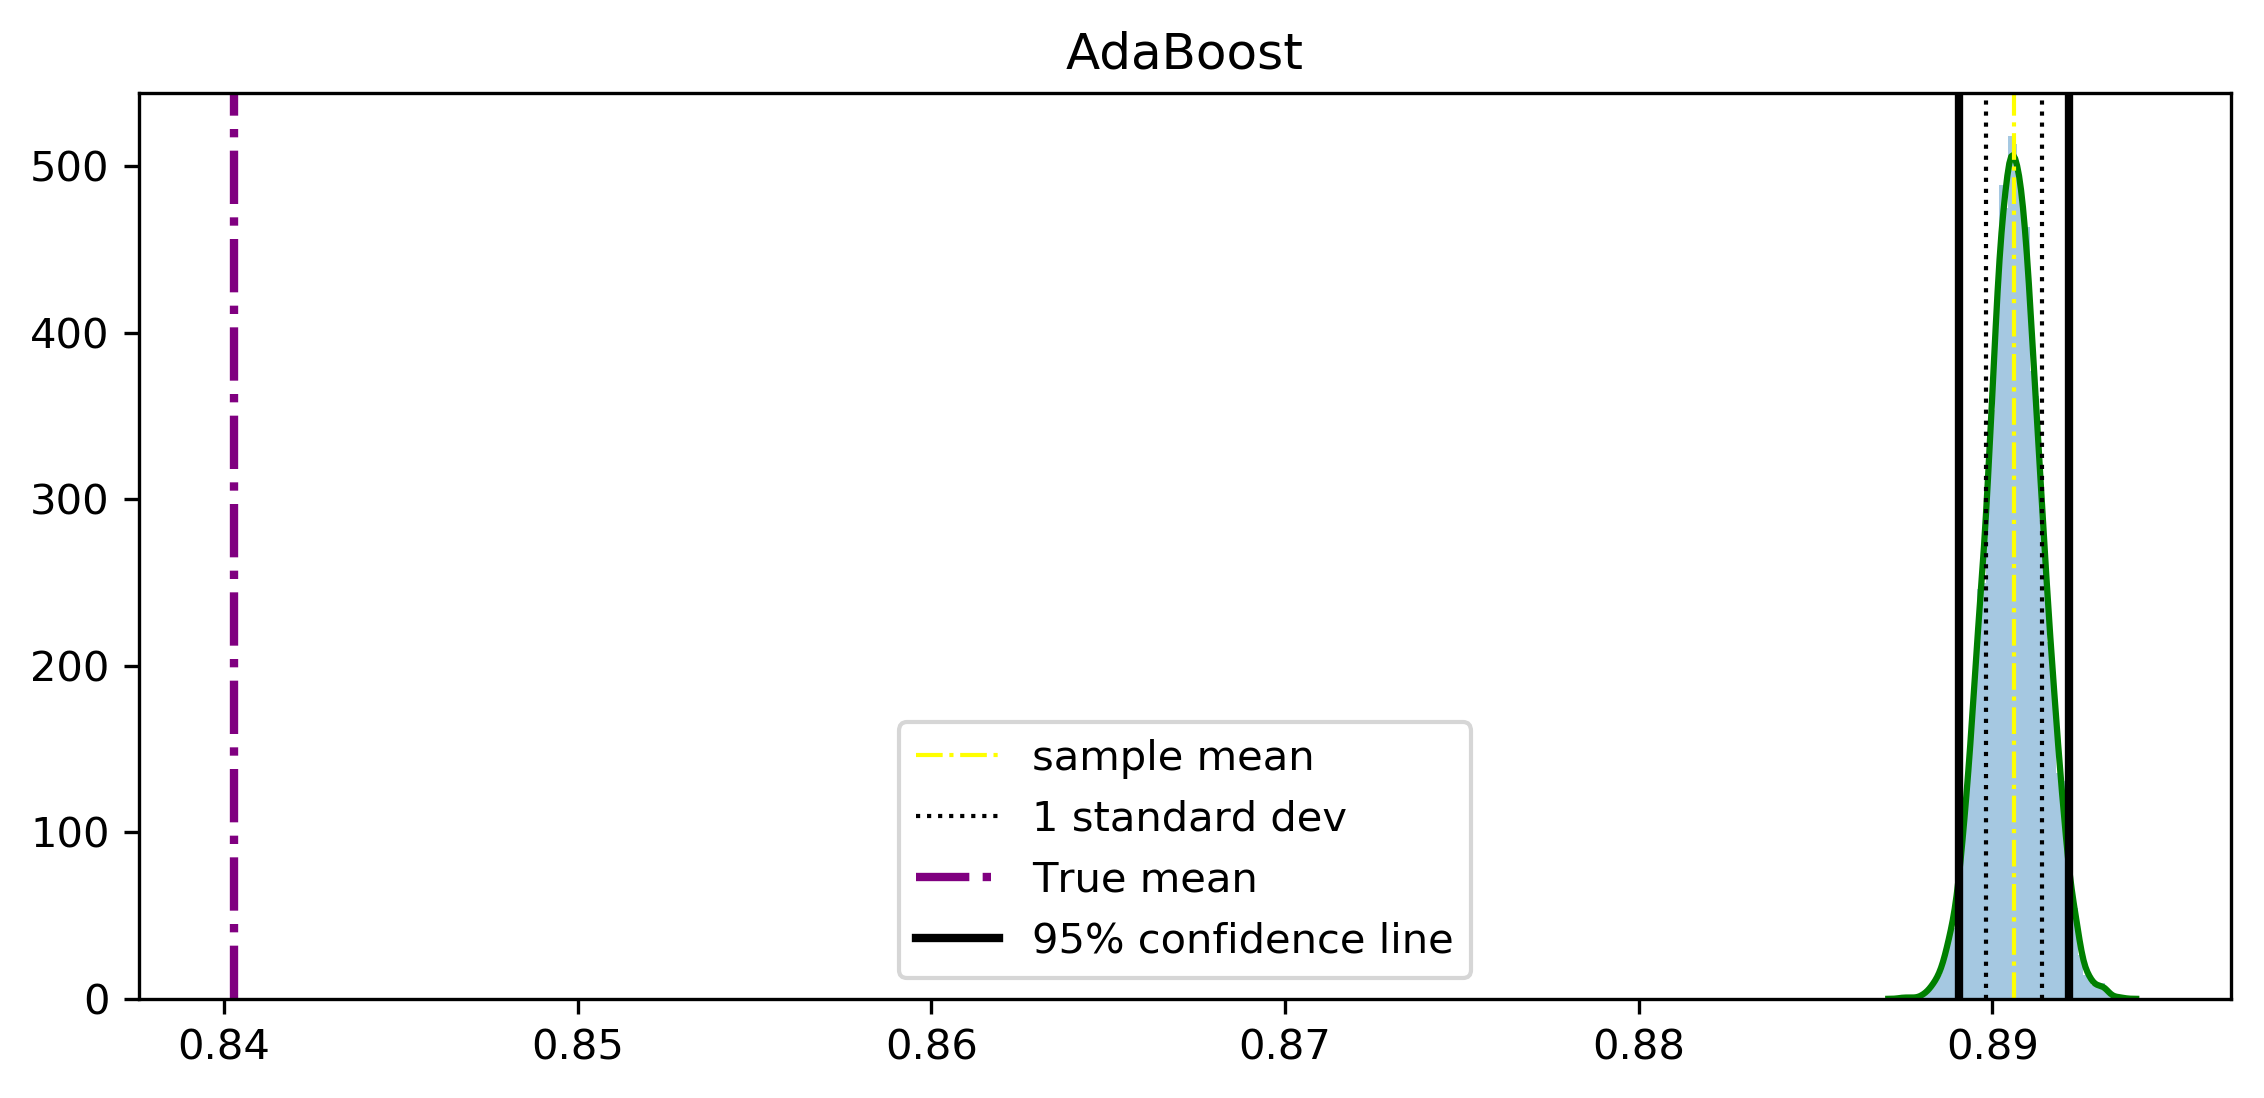

In [58]:
Hypothesis_test(sampling_dist,'AdaBoost')

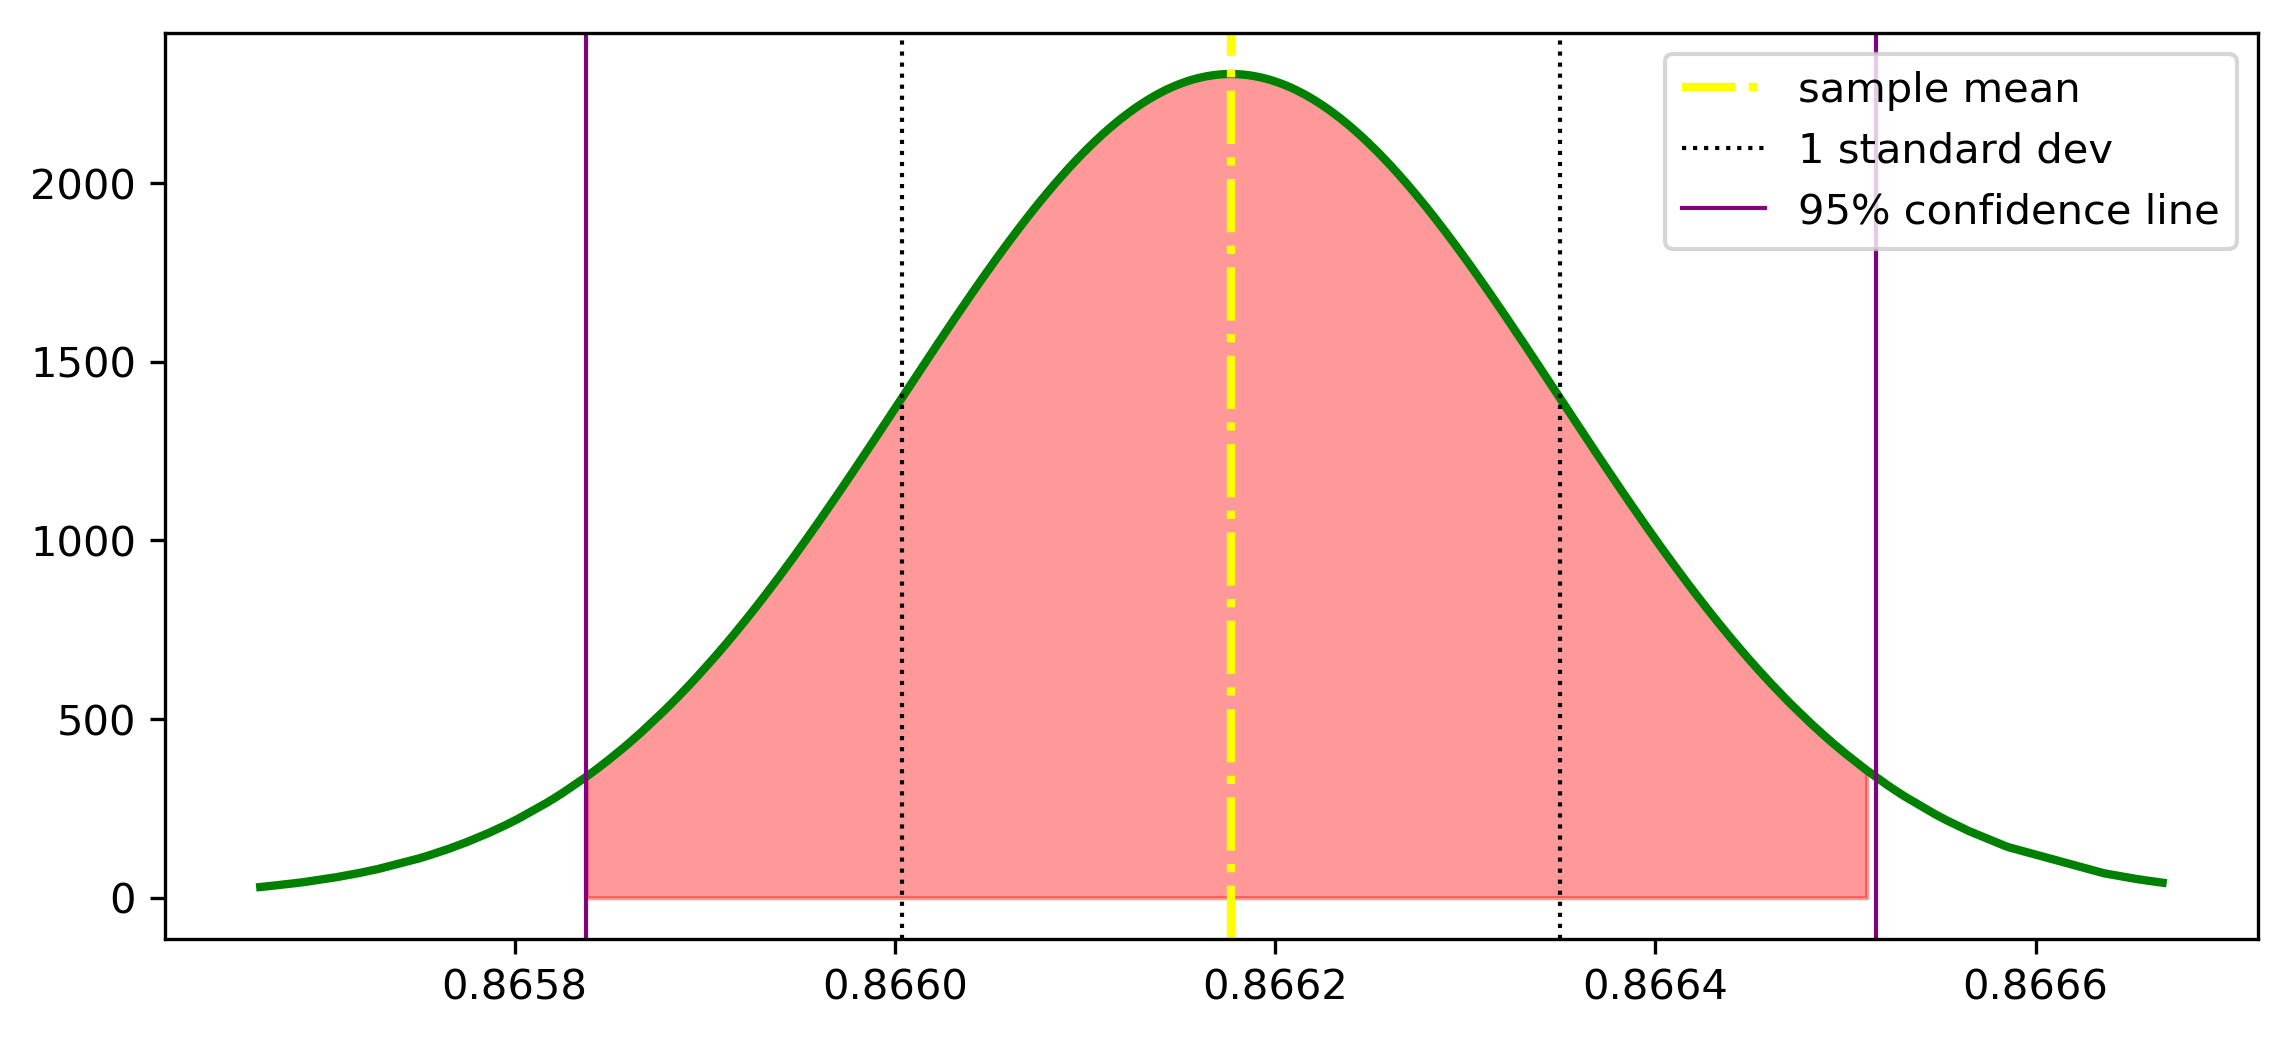

In [99]:
lower_bound = train_acc_mean - (train_acc_SE*abs(st.norm.ppf(.025)))
upper_bound = train_acc_mean + (train_acc_SE*abs(st.norm.ppf(.025)))
plot_norm(train_acc_mean,train_acc_SE,1000,lower_bound,upper_bound)

* f-beta(0.5) of Ada Boost is more as compared to a Logistic regression model and I think with further cross validation and Gridsearch CV I can find the best model.